In [1]:
from datasets import load_dataset,load_from_disk
import datasets
import re
import random
import ast
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load dataset and save to local

In [1]:
dataset = load_dataset("ai4privacy/pii-masking-300k")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to C:/Users/User/.cache/huggingface/datasets/ai4privacy___json/ai4privacy--pii-masking-300k-ea412926aeaada9c/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
dataset.save_to_disk("pii-masking-300k.json")

Saving the dataset (0/2 shards):   0%|          | 0/177677 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/47728 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
        num_rows: 177677
    })
    validation: Dataset({
        features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
        num_rows: 47728
    })
})

# Split train set into three pieces

One for SFT, one for reward model, and one for PPO.

In [12]:
sft_train = dataset['train'].train_test_split(test_size=0.666666)
reward_data = sft_train['test'].train_test_split(test_size=0.5)
ppo_train = reward_data['test']
sft_train = sft_train['train']
reward_data = reward_data['train']
print(sft_train)
print(reward_data)
print(ppo_train)

Dataset({
    features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
    num_rows: 59225
})
Dataset({
    features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
    num_rows: 59226
})
Dataset({
    features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
    num_rows: 59226
})


In [13]:
sft_train.save_to_disk("pii-masking-300k-split/sft-train")
reward_data.save_to_disk("pii-masking-300k-split/reward-data")
ppo_train.save_to_disk("pii-masking-300k-split/ppo-train")
dataset['validation'].save_to_disk("pii-masking-300k-split/test")

Saving the dataset (0/1 shards):   0%|          | 0/59225 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/59226 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/59226 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/47728 [00:00<?, ? examples/s]

# Check labels

In [5]:
dataset = load_dataset("ai4privacy/pii-masking-300k")

english_dataset = dataset.filter(lambda example: example['language'] == 'English')

train_dataset_raw = english_dataset["train"]
valid_dataset_raw  = english_dataset["validation"]

Using custom data configuration ai4privacy--pii-masking-300k-507d25b4ab67b359
Reusing dataset json (C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?ba/s]

  0%|          | 0/48 [00:00<?, ?ba/s]

In [20]:
len(train_dataset_raw), len(valid_dataset_raw), len(dataset["train"])

(29908, 7946, 177677)

In [15]:
unique_labels = []
for labels in train_dataset_raw['span_labels']:
    #print(labels)
    pattern = r'"(.*?)"'
    matches = re.findall(pattern, labels)
    for l in matches:
        #print(l)
        if not l in unique_labels:
            unique_labels.append(l)

In [16]:
unique_labels

['USERNAME',
 'TIME',
 'SOCIALNUMBER',
 'EMAIL',
 'LASTNAME2',
 'LASTNAME1',
 'DATE',
 'STATE',
 'CITY',
 'STREET',
 'BUILDING',
 'COUNTRY',
 'IDCARD',
 'PASS',
 'POSTCODE',
 'PASSPORT',
 'TEL',
 'DRIVERLICENSE',
 'BOD',
 'SEX',
 'IP',
 'LASTNAME3',
 'SECADDRESS',
 'TITLE',
 'GIVENNAME2',
 'GIVENNAME1',
 'GEOCOORD',
 'CARDISSUER']

In [17]:
len(unique_labels)

28

In [22]:
unique_labels_test = []
for labels in valid_dataset_raw['span_labels']:
    #print(labels)
    pattern = r'"(.*?)"'
    matches = re.findall(pattern, labels)
    for l in matches:
        #print(l)
        if not l in unique_labels_test:
            unique_labels_test.append(l)

In [23]:
len(unique_labels_test)

28

In [21]:
marker_categories = ['LASTNAME1', 'LASTNAME2', 'LASTNAME3', 'GIVENNAME1', 'GIVENNAME2', 'BOD', 'TIME',  'STREET', 'CITY', 'STATE', 'SEX','DATE', 'USERNAME', 'IDCARD', 'SECADDRESS', 'POSTCODE', 'TITLE', 'TEL', 'COUNTRY']  
len(marker_categories)

19

# Take 50% of validation set with only english as test

In [2]:
dataset = load_dataset("ai4privacy/pii-masking-300k")

english_dataset = dataset.filter(lambda example: example['language'] == 'English')

train_dataset_raw = english_dataset["train"]
valid_dataset_raw  = english_dataset["validation"]

Using custom data configuration ai4privacy--pii-masking-300k-507d25b4ab67b359
Reusing dataset json (C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-019dc1ae51598c0a.arrow
Loading cached processed dataset at C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-b75c20b3b7ce8a4c.arrow


In [9]:
test_set = valid_dataset_raw.train_test_split(test_size=0.5, seed=42)['test']

Loading cached split indices for dataset at C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-a3b6fe5770a8f74e.arrow and C:\Users\User\.cache\huggingface\datasets\ai4privacy___json\ai4privacy--pii-masking-300k-507d25b4ab67b359\0.0.0\a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253\cache-edc9b94b3015f4fc.arrow


In [13]:
unique_labels_test = []
for labels in test_set['span_labels']:
    #print(labels)
    pattern = r'"(.*?)"'
    matches = re.findall(pattern, labels)
    for l in matches:
        #print(l)
        if not l in unique_labels_test:
            unique_labels_test.append(l)

In [15]:
len(unique_labels_test),unique_labels_test

(28,
 ['TIME',
  'PASS',
  'IP',
  'LASTNAME1',
  'GIVENNAME1',
  'TITLE',
  'BUILDING',
  'DATE',
  'IDCARD',
  'USERNAME',
  'SOCIALNUMBER',
  'SEX',
  'LASTNAME2',
  'EMAIL',
  'GIVENNAME2',
  'DRIVERLICENSE',
  'STATE',
  'BOD',
  'GEOCOORD',
  'SECADDRESS',
  'POSTCODE',
  'CITY',
  'STREET',
  'COUNTRY',
  'PASSPORT',
  'TEL',
  'LASTNAME3',
  'CARDISSUER'])

In [17]:
test_set.save_to_disk("pii-masking-300k-llama2-sft/test")

Flattening the indices:   0%|          | 0/4 [00:00<?, ?ba/s]

# Remove some labels, merge some labels

In [2]:
dataset = load_dataset("ai4privacy/pii-masking-300k")

english_dataset = dataset.filter(lambda example: example['language'] == 'English')

train_dataset_raw = english_dataset["train"]
valid_dataset_raw  = english_dataset["validation"]

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\datasets--ai4privacy--pii-masking-300k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Filter: 100%|███████████████████████████████████████████████████████████| 47728/47728 [00:25<

In [3]:
labels = ['TIME',
 'USERNAME',
 'SOCIALNUMBER',
 'IDCARD',
 'EMAIL',
 'LASTNAME1',
 'PASSPORT',
 'DRIVERLICENSE',
 'BOD',
 'IP',
 'GIVENNAME1',
 'CITY',
 'TITLE',
 'SEX',
 'STATE',
 'POSTCODE',
 'BUILDING',
 'STREET',
 'TEL',
 'DATE',
 'COUNTRY',
 'PASS',
 'SECADDRESS',
 'LASTNAME2',
 'GIVENNAME2',
 'LASTNAME3',
 'GEOCOORD',
 'CARDISSUER']
len(labels)

28

In [4]:
name_labels = ['LASTNAME1', 'LASTNAME2', 'LASTNAME3', 'GIVENNAME1', 'GIVENNAME2', 'CARDISSUER']

In [5]:
IDs_label = ['SOCIALNUMBER', 'IDCARD', 'PASSPORT', 'DRIVERLICENSE',]

In [6]:
DATE_label = []

In [7]:
remove_labels = ['CITY','STATE','COUNTRY', 'SEX', 'POSTCODE', 'BOD', 'DATE', 'GEOCOORD', 'BUILDING', 'TITLE', 'TIME',]

In [8]:
new_labels = [item for item in labels if item not in name_labels and item not in IDs_label and item not in remove_labels and item not in DATE_label]

In [9]:
len(new_labels)

7

In [10]:
def label_spans(text, labels_with_locations):
    """
    Convert spans in the text to the corresponding labels.

    :param text: The input text (string).
    :param labels_with_locations: List of tuples with (start_index, end_index, label).
                                  Example: [(0, 5, "PERSON"), (15, 18, "ORG")]
    :return: Labeled text (string) with spans replaced by labels.
    """
    # Sort the labels by start index to handle nested or overlapping spans
    labels_with_locations.sort(key=lambda x: x[0])

    labeled_text = ""
    last_index = 0

    for start, end, label in labels_with_locations:
        # Append the text before the span
        labeled_text += text[last_index:start]
        # Append the label in place of the span
        labeled_text += f"[{label}]"
        # Update the last index to end of current span
        last_index = end

    # Append the remaining part of the text
    labeled_text += text[last_index:]

    return labeled_text

In [11]:
converted_list = ast.literal_eval(train_dataset_raw[0]['span_labels'])

In [12]:
converted_list

[[440, 453, 'USERNAME'],
 [430, 437, 'TIME'],
 [395, 416, 'USERNAME'],
 [377, 392, 'TIME'],
 [349, 363, 'USERNAME'],
 [344, 346, 'TIME'],
 [321, 330, 'USERNAME'],
 [311, 318, 'TIME'],
 [287, 297, 'USERNAME']]

In [13]:
label_spans(train_dataset_raw[0]['source_text'], converted_list)

'Subject: Group Messaging for Admissions Process\n\nGood morning, everyone,\n\nI hope this message finds you well. As we continue our admissions processes, I would like to update you on the latest developments and key information. Please find below the timeline for our upcoming meetings:\n\n- [USERNAME] - Meeting at [TIME]\n- [USERNAME] - Meeting at [TIME]\n- [USERNAME] - Meeting at [TIME]\n- [USERNAME] - Meeting at [TIME]\n- [USERNAME] '

In [14]:
train_dataset_raw[0]['target_text']

'Subject: Group Messaging for Admissions Process\n\nGood morning, everyone,\n\nI hope this message finds you well. As we continue our admissions processes, I would like to update you on the latest developments and key information. Please find below the timeline for our upcoming meetings:\n\n- [USERNAME] - Meeting at [TIME]\n- [USERNAME] - Meeting at [TIME]\n- [USERNAME] - Meeting at [TIME]\n- [USERNAME] - Meeting at [TIME]\n- [USERNAME] '

In [15]:
new_targe_text = []
new_span_labels_list = []
for instance in train_dataset_raw:
    converted_span_labels = ast.literal_eval(instance['span_labels'])
    new_span_labels = []
    for l in converted_span_labels:
        if l[2] in name_labels:
            new_span_labels.append([l[0], l[1], "NAME"])
        elif l[2] in IDs_label:
            new_span_labels.append([l[0], l[1], "ID"])
        elif l[2] in DATE_label:
            new_span_labels.append([l[0], l[1], "DATE"])
        elif l[2] in new_labels:
            new_span_labels.append([l[0], l[1], l[2]])
            
    new_span_labels_list.append(str(new_span_labels))
    new_targe_text.append(label_spans(instance['source_text'], new_span_labels))

In [16]:
len(new_targe_text)

29908

In [17]:
len(new_span_labels_list)

29908

In [25]:
train_df = train_dataset_raw.to_pandas()

In [26]:
new_train_df = train_df[['source_text', 'target_text', 'span_labels', 'id']]

In [27]:
train_df[['source_text', 'target_text', 'span_labels', 'id']]

,source_text,target_text,span_labels,id
0,Subject: Group Messaging for Admissions Proces...,Subject: Group Messaging for Admissions Proces...,"[[440, 453, ""USERNAME""], [430, 437, ""TIME""], [...",40767A
1,- Meeting at 2:33 PM\n- N23 - Meeting at 11:29...,- Meeting at [TIME]\n- [USERNAME] - Meeting at...,"[[74, 81, ""TIME""], [50, 60, ""USERNAME""], [40, ...",40767B
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...",40768A
3,Card: KB90324ER\n Country: GB\n Building: ...,Card: [IDCARD]\n Country: [COUNTRY]\n Buil...,"[[390, 393, ""STATE""], [368, 378, ""CITY""], [346...",40768B
4,"N, WA14 5RW\n Password: r]iD1#8\n\n...and so...","N, WA14 5RW\n Password: [PASS]\n\n...and so ...","[[336, 352, ""DATE""], [26, 33, ""PASS""]]",40768C
...,...,...,...,...
29903,e of Birth: [18/01/1962]\n - Passport Number...,e of Birth: [[BOD]]\n - Passport Number: [[P...,"[[379, 384, ""POSTCODE""], [360, 361, ""TIME""], [...",53616B
29904,"2022, in New York City. The assessment include...","2022, in New York City. The assessment include...",[],53616C
29905,Art Therapy Code of Ethics:\n\nNotice to all a...,Art Therapy Code of Ethics:\n\nNotice to all a...,"[[410, 419, ""IDCARD""]]",53617A
29906,"72330716, 8015553273660, N60324048, 743010413,...","72330716, [IDCARD], [IDCARD], [IDCARD], [IDCAR...","[[380, 397, ""TEL""], [363, 378, ""TEL""], [350, 3...",53617B


In [28]:
new_train_df['target_text'] = new_targe_text
new_train_df['span_labels'] = new_span_labels_list

C:\Users\USER\AppData\Local\Temp\ipykernel_66024\2892181375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_df['target_text'] = new_targe_text
C:\Users\USER\AppData\Local\Temp\ipykernel_66024\2892181375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_df['span_labels'] = new_span_labels_list


In [29]:
new_train_df

,source_text,target_text,span_labels,id
0,Subject: Group Messaging for Admissions Proces...,Subject: Group Messaging for Admissions Proces...,"[[440, 453, 'USERNAME'], [395, 416, 'USERNAME'...",40767A
1,- Meeting at 2:33 PM\n- N23 - Meeting at 11:29...,- Meeting at 2:33 PM\n- [USERNAME] - Meeting a...,"[[50, 60, 'USERNAME'], [23, 26, 'USERNAME']]",40767B
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[[395, 407, 'ID'], [358, 375, 'EMAIL'], [339, ...",40768A
3,Card: KB90324ER\n Country: GB\n Building: ...,Card: [ID]\n Country: GB\n Building: 163\n...,"[[346, 357, 'STREET'], [278, 287, 'ID'], [252,...",40768B
4,"N, WA14 5RW\n Password: r]iD1#8\n\n...and so...","N, WA14 5RW\n Password: [PASS]\n\n...and so ...","[[26, 33, 'PASS']]",40768C
...,...,...,...,...
29903,e of Birth: [18/01/1962]\n - Passport Number...,e of Birth: [18/01/1962]\n - Passport Number...,"[[301, 310, 'ID'], [217, 226, 'ID'], [125, 134...",53616B
29904,"2022, in New York City. The assessment include...","2022, in New York City. The assessment include...",[],53616C
29905,Art Therapy Code of Ethics:\n\nNotice to all a...,Art Therapy Code of Ethics:\n\nNotice to all a...,"[[410, 419, 'ID']]",53617A
29906,"72330716, 8015553273660, N60324048, 743010413,...","72330716, [ID], [ID], [ID], [ID], [ID], [ID], ...","[[380, 397, 'TEL'], [363, 378, 'TEL'], [350, 3...",53617B


In [30]:
new_train_dataset = Dataset.from_pandas(new_train_df)

In [31]:
new_train_dataset = new_train_dataset.train_test_split(test_size=0.3, seed=42)

In [32]:
new_train_dataset.save_to_disk("pii-masking-300k-with-new-labels-v2/train")

Saving the dataset (1/1 shards): 100%|██████████████████████████████████| 8973/8973 [00:00<00:00, 182796.82 examples/s]


In [33]:
new_targe_text = []
new_span_labels_list = []
for instance in valid_dataset_raw:
    converted_span_labels = ast.literal_eval(instance['span_labels'])
    new_span_labels = []
    for l in converted_span_labels:
        if l[2] in name_labels:
            new_span_labels.append([l[0], l[1], "NAME"])
        elif l[2] in IDs_label:
            new_span_labels.append([l[0], l[1], "ID"])
        elif l[2] in DATE_label:
            new_span_labels.append([l[0], l[1], "DATE"])
        elif l[2] in new_labels:
            new_span_labels.append([l[0], l[1], l[2]])
    new_span_labels_list.append(str(new_span_labels))
    new_targe_text.append(label_spans(instance['source_text'], new_span_labels))

In [34]:
test_df = valid_dataset_raw.to_pandas()
new_test_df = test_df[['source_text', 'target_text', 'span_labels', 'id']]

In [35]:
test_df[['source_text', 'target_text', 'span_labels', 'id']]

,source_text,target_text,span_labels,id
0,On the video sharing platform for educational ...,On the video sharing platform for educational ...,"[[316, 320, ""USERNAME""], [254, 272, ""USERNAME""...",40770A
1,d wsfdkmi9214 shared personal experiences rela...,d [USERNAME] shared personal experiences relat...,"[[355, 356, ""USERNAME""], [339, 350, ""USERNAME""...",40770B
2,ach other respectfully in their comments. yega...,ach other respectfully in their comments. [USE...,"[[339, 344, ""TIME""], [61, 74, ""USERNAME""], [42...",40770C
3,"{\n ""Guidelines"": {\n ""maximumAge"": ""May 5...","{\n ""Guidelines"": {\n ""maximumAge"": ""[BOD]...","[[432, 441, ""IDCARD""], [391, 400, ""IDCARD""], [...",40771
4,Subject: Collaboration Opportunity in Online C...,Subject: Collaboration Opportunity in Online C...,[],40779A
...,...,...,...,...
7941,ategies.\n\n---\n\nThank you for participating...,ategies.\n\n---\n\nThank you for participating...,"[[354, 365, ""TITLE""], [210, 233, ""EMAIL""], [16...",53607D
7942,**Art Therapy Informed Consent Form**\n\n**Cli...,**Art Therapy Informed Consent Form**\n\n**Cli...,"[[134, 144, ""DRIVERLICENSE""], [72, 101, ""EMAIL""]]",53610A
7943,sonal growth and insight.\n\n**Limitations of ...,sonal growth and insight.\n\n**Limitations of ...,[],53610B
7944,```yaml\nArt_Therapy_Confidentiality_Waiver:\n...,```yaml\nArt_Therapy_Confidentiality_Waiver:\n...,"[[291, 301, ""BOD""]]",53614A


In [36]:
new_test_df['target_text'] = new_targe_text
new_test_df['span_labels'] = new_span_labels_list

C:\Users\USER\AppData\Local\Temp\ipykernel_66024\2992013001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_df['target_text'] = new_targe_text
C:\Users\USER\AppData\Local\Temp\ipykernel_66024\2992013001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_df['span_labels'] = new_span_labels_list


In [37]:
new_test_dataset = Dataset.from_pandas(new_test_df)

In [38]:
new_test_dataset = new_test_dataset.train_test_split(test_size=0.5, seed=42)['test']

In [39]:
new_test_dataset.save_to_disk("pii-masking-300k-with-new-labels-v2/test")

Saving the dataset (1/1 shards): 100%|██████████████████████████████████| 3973/3973 [00:00<00:00, 141632.98 examples/s]


# Statistics of Dataset with New Labels

In [33]:
train_set = load_from_disk("pii-masking-300k-with-new-labels/train")
test_set = load_from_disk("pii-masking-300k-with-new-labels/test")

In [34]:
train_set

DatasetDict({
    train: Dataset({
        features: ['source_text', 'target_text', 'span_labels', 'id'],
        num_rows: 20935
    })
    test: Dataset({
        features: ['source_text', 'target_text', 'span_labels', 'id'],
        num_rows: 8973
    })
})

In [35]:
test_set

Dataset({
    features: ['source_text', 'target_text', 'span_labels', 'id'],
    num_rows: 3973
})

In [36]:
train_label_counts = {}
for row in train_set['train']:
    labels = ast.literal_eval(row['span_labels'])
    for l in labels:
        if not l[2] in train_label_counts.keys():
            train_label_counts.update({l[2]:1})
        else:
            train_label_counts[l[2]] += 1
print(train_label_counts)

{'SECADDRESS': 2207, 'STREET': 5069, 'BUILDING': 5127, 'TEL': 5019, 'ID': 25877, 'EMAIL': 6719, 'USERNAME': 7757, 'NAME': 15333, 'TITLE': 5288, 'TIME': 10210, 'DATE': 10617, 'IP': 5755, 'PASS': 3992, 'GEOCOORD': 499}


In [37]:
val_label_counts = {}
for row in train_set['test']:
    labels = ast.literal_eval(row['span_labels'])
    for l in labels:
        if not l[2] in val_label_counts.keys():
            val_label_counts.update({l[2]:1})
        else:
            val_label_counts[l[2]] += 1
print(val_label_counts)

{'ID': 11049, 'EMAIL': 3040, 'DATE': 4624, 'PASS': 1645, 'STREET': 2290, 'BUILDING': 2256, 'NAME': 6744, 'TITLE': 2272, 'TIME': 4466, 'IP': 2390, 'USERNAME': 3358, 'GEOCOORD': 204, 'TEL': 2293, 'SECADDRESS': 910}


In [38]:
test_label_counts = {}
for row in test_set:
    labels = ast.literal_eval(row['span_labels'])
    for l in labels:
        if not l[2] in test_label_counts.keys():
            test_label_counts.update({l[2]:1})
        else:
            test_label_counts[l[2]] += 1
print(test_label_counts)

{'TIME': 1890, 'PASS': 816, 'IP': 1120, 'NAME': 2950, 'TITLE': 969, 'BUILDING': 956, 'DATE': 2033, 'ID': 4970, 'USERNAME': 1453, 'EMAIL': 1340, 'GEOCOORD': 112, 'SECADDRESS': 417, 'STREET': 939, 'TEL': 960}


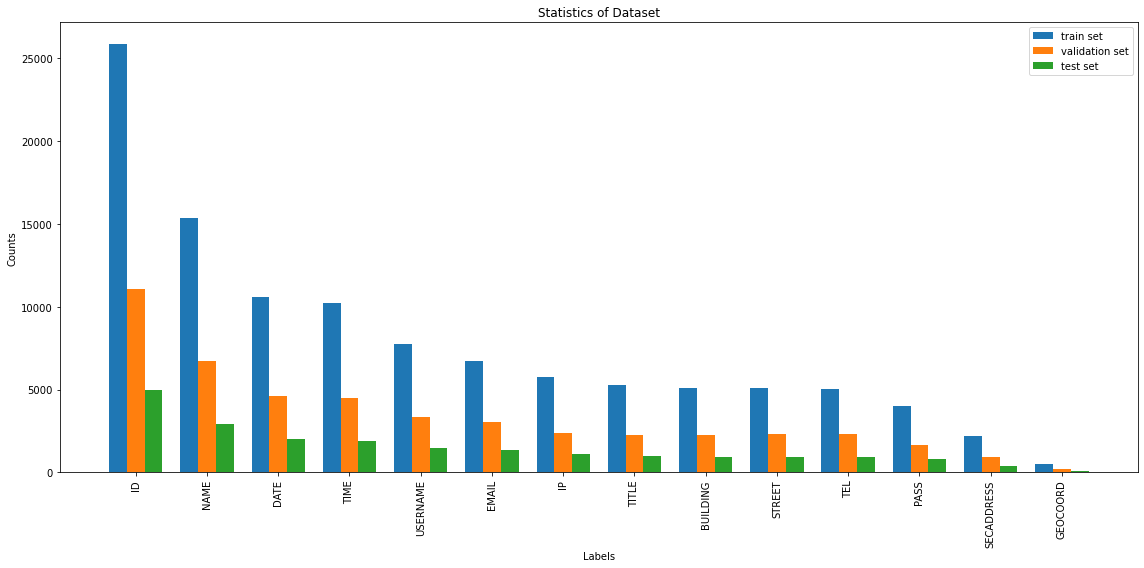

In [39]:
# Sort keys by values in dict1
sorted_keys = sorted(train_label_counts, key=train_label_counts.get, reverse=True)

# Get values sorted according to sorted_keys
values1 = [train_label_counts[key] for key in sorted_keys]
values2 = [val_label_counts.get(key, 0) for key in sorted_keys]
values3 = [test_label_counts.get(key, 0) for key in sorted_keys]

# Create the plot
x = np.arange(len(sorted_keys))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, values1, width, label='train set')
rects2 = ax.bar(x, values2, width, label='validation set')
rects3 = ax.bar(x + width, values3, width, label='test set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Statistics of Dataset')
ax.set_xticks(x)
ax.set_xticklabels(sorted_keys, rotation=90)
ax.legend()

# Automatically adjust the subplot parameters to give some padding
fig.tight_layout()

plt.show()